### Constructing a combined dataset from multiple sources
Something here.

In [21]:
import pandas as pd
import numpy as np
import time
import sys
import os
import gensim
import warnings
import itertools
import multiprocessing as mp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Other modules imported from the local package.
sys.path.append("../../oats")
from oats.utils.utils import save_to_pickle, load_from_pickle
from oats.utils.utils import function_wrapper, to_hms

# Setting some options to make notebook output clearer.
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.multi_sparse', False)
warnings.simplefilter('ignore')

In [3]:
from oats.datasets.dataset import Dataset

# Put together a complete dataset from files that have been formatted correctly in the other notebooks.
dataset = Dataset()
dataset.add_data(pd.read_csv("../data/reshaped_files/ath_tair_gene_text.csv", lineterminator="\n"))
dataset.add_data(pd.read_csv("../data/reshaped_files/ath_tair_gene_annot_go.csv", lineterminator="\n"))
#dataset.add_data(pd.read_csv("../data/reshaped_files/ath_tair_gene_annot_po.csv", lineterminator="\n"))
dataset.collapse_by_first_gene_name()
dataset.filter_has_description()
dataset.filter_has_annotation()
dataset.describe()

Number of rows in the dataframe: 5229
Number of unique IDs:            5229
Number of unique descriptions:   3051
Number of unique gene name sets: 5229
Number of species represented:   1


### Looking at what pathways or groups are represented by genes in that dataset
something more here

In [4]:
from oats.datasets.groupings import Groupings
from oats.utils.utils import merge_list_dicts


genes = dataset.get_gene_dictionary()

# Create/read in the different objects for organizing gene groupings.
groupings_kegg = load_from_pickle(path="../data/pickles/kegg_pathways.pickle")
groupings_pmn = load_from_pickle(path="../data/pickles/pmn_pathways.pickle")
groupings_subset = load_from_pickle(path="../data/pickles/lloyd_subsets.pickle")
groupings_class = load_from_pickle(path="../data/pickles/lloyd_classes.pickle")

# Get mappings between object IDs and pathways IDs and the reverse.
id_to_pathway_ids = merge_list_dicts(
    groupings_kegg.get_forward_dict(genes),
    groupings_pmn.get_forward_dict(genes),
    groupings_subset.get_forward_dict(genes))

# Show some mappings between IDs and groups where the ID belongs to atleast one.
total = len(id_to_pathway_ids.keys())
has_mapping = len([k for (k,v) in id_to_pathway_ids.items() if len(v)>0])
print("Of the {} genes in the dataset, {} are mapped to atleast one pathway.".format(total, has_mapping))
for k,v in [(k,v) for (k,v) in id_to_pathway_ids.items() if len(v)>0][:25]:
# Wh at    print("{0:<8}{1:<}".format(k," ".join(v)[:80]))

Of the 5229 genes in the dataset, 661 are mapped to atleast one pathway.
16      PWY-5080 PWY-7036
18      PWY-6
19      PWY-6733
21      PWY-7270 ETHYL-PWY
22      PWY-181
24      PWY-5667 TRIGLSYN-PWY
31      PWY-6295 PWY-6733 PWY-84
36      PWY-282
44      PWY-6898 PWY-7356 PWY-6908
49      LEU-DEG2-PWY
55      PWY-622
57      HEME-BIOSYNTHESIS-II CHLOROPHYLL-SYN
61      PWY-6745
68      PWY-581 PWYDQC-4
69      PWY-5080
77      PWY-6446 PWY-6444 PWY-3181
79      PWY-5136
89      PWY-6363 PWY-6364
90      PWY-5272 PWY-1782 PWY-1741
91      PWY-6363 PWY-6364
101     PWY-5136 PWY-6837
103     PWY-6773
104     PWY-5129
105     PWY-5667 TRIGLSYN-PWY
109     PWY-6475


In [72]:
# TODO why are their duplicates in the lists which are values in that dict????
# Check why duplicates aren't being removed there.




# Get a mapping that goes the other way, from pathway IDs to object IDs.
pathway_id_to_ids = merge_list_dicts(
    groupings_kegg.get_reverse_dict(genes),
    groupings_pmn.get_reverse_dict(genes),
    groupings_subset.get_reverse_dict(genes))

pathway_id_to_ids = groupings_pmn.get_reverse_dict(genes)

# Show some mappings between group IDs and IDs where the group has atleast two gene in the dataset.
total = len(pathway_id_to_ids.keys())
has_mapping = len([k for (k,v) in pathway_id_to_ids.items() if len(v)>1])
print("Of the {} groups in the dataset, {} are mapped to atleast one gene.".format(total, has_mapping))
for k,v in [(k,v) for (k,v) in pathway_id_to_ids.items() if len(v)>1][:20]:
    print("{0:<30}{1:<}".format(k[:27]," ".join([str(x) for x in v][:15])))

Of the 421 groups in the dataset, 324 are mapped to atleast one gene.
PWY-5080                      16 16 16 16 69 745 1124 1440 2026 2406 2581 2585 2585 2585 2585
PWY-7036                      16 16 16 16 16 16 16 16 16 16 745 1550 2026 2026 2026
PWY-6                         18 18
PWY-6733                      19 31 321 321 321 321 515 515 515 662 662 662 662 686 686
PWY-7270                      21 1698 1951 2102 2209 2235 2465 2632 3471
ETHYL-PWY                     21 192 1698 1951 2102 2209 2235 2465 2632 3471
PWY-181                       22 360 737 905 2635
PWY-5667                      24 105 443 691 1615 2056 2091 2139 2518
TRIGLSYN-PWY                  24 105 443 691 1029 1615 2056 2139 2518
PWY-6295                      31 2592
PWY-84                        31 2592
PWY-282                       36 2574 3342
PWY-7356                      44 354 354 354 2502 3047
PWY-6908                      44 354 2502
LEU-DEG2-PWY                  49 49 168 169 526 780 1132 1642 1696 1739 

In [75]:
# How many occurences are there of a specific gene pair sharing atleast one pathway?
unique_gene_id_pairs = set()
for gene_id_list in pathway_id_to_ids.values():
    gene_id_pairs = list(itertools.combinations(gene_id_list, 2))
    sorted_gene_id_pairs = [tuple(sorted(x)) for x in gene_id_pairs]
    unique_gene_id_pairs.update(sorted_gene_id_pairs)
print(len(unique_gene_id_pairs))

2707


1
45


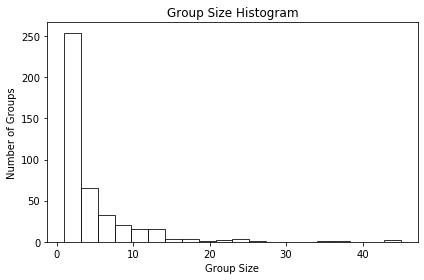

In [76]:
# What about the distributions of membership for each of the groupings?
x = [len(v) for v in pathway_id_to_ids.values()]
print(min(x))
print(max(x))
plt.hist(x, bins=20, range=(1,45), density=False, alpha=0.8, histtype='bar', color='white', edgecolor='black')
plt.title("Group Size Histogram")
plt.xlabel("Group Size")
plt.ylabel("Number of Groups")
plt.tight_layout()

### Subsetting the dataset and looking at what information is present
something more here

In [77]:
# Subset the dataset to retain only the genes that are mapped to atleast one group.
dataset.filter_with_ids([k for k,v in id_to_pathway_ids.items() if len(v)>0])
dataset.describe()

Number of rows in the dataframe: 661
Number of unique IDs:            661
Number of unique descriptions:   588
Number of unique gene name sets: 661
Number of species represented:   1


In [78]:
# Get mapping from IDs to gene objects.
genes = dataset.get_gene_dictionary()
for k,v in list(genes.items())[:10]:
    print("{0:<8}{1:<}".format(k," ".join(v.names)))

0       AT1G01120
1       AT1G01220
2       AT1G01280
3       AT1G01480
4       AT1G01510
5       AT1G01610
6       AT1G02050
7       AT1G02205
8       AT1G02880
9       AT1G03090


In [79]:
# Get a mapping from IDs to annotations (lists of ontology terms).
annotations = dataset.get_annotations_dictionary()
for k,v in list(annotations.items())[:10]:
    print("{0:<8}{1:<}".format(k," ".join(v)[:88])) 

0       GO:0022626 GO:0042335 GO:0000038 GO:0009805 GO:0005783 GO:0010025 GO:0009409 GO:0030497 
1       GO:0047341 GO:0042352 GO:0004335 GO:0050201 GO:0005524 GO:0005737 GO:0030244 GO:0048193
2       GO:0080110 GO:0010584 GO:0010208 GO:0016709 GO:0019825 GO:0051792 GO:0051791
3       GO:0005737 GO:0009693 GO:0016847
4       GO:0031129 GO:0009965 GO:0042802 GO:0005802 GO:0042814 GO:2000039 GO:0051225 GO:0042803 
5       GO:0009926 GO:0043481 GO:0016746 GO:0042335 GO:0000038 GO:0008152 GO:0040007 GO:0048767 
6       GO:0010584 GO:0009699 GO:0030639 GO:0005783 GO:0080110 GO:0090439 GO:0005737
7       GO:0042335 GO:0009414 GO:0042742 GO:0043447 GO:0046185 GO:0050832 GO:0010025 GO:0071771
8       GO:0005737 GO:0006772 GO:0005829 GO:0004788
9       GO:0005739 GO:0022626 GO:0050897 GO:0006552 GO:0004485 GO:0009744 GO:0009750


In [80]:
from oats.nlp.preprocess import get_clean_description

# Get a mapping from IDs to text descriptions.
descriptions = dataset.get_description_dictionary()
descriptions = {i:get_clean_description(d) for (i,d) in descriptions.items()}
for k,v in list(descriptions.items())[:10]:
    print("{0:<8}{1:<}".format(k,v[:80]))

0       thin stems sensitive to low humidity
1       fkgp1 mutants have about 40 times more lfucose than wild type arabidopsis plants
2       slightly longer inflorescences an extended period of blooming a reduced number o
3       enhanced hypocotyl length in lightgrown seedlings enlarged cotyledons increased 
4       lacks trichomes on stems and leaves some rudimentary trichomes in leaf margins n
5       this double knockout mutant has a 6070 overall decrease in cutin monomer content
6       abnormal exine patterning pollen has a more extensively covered surface with bro
7       very bright green stems and siliques complete absence of lobed plates and tubesh
8       the attpk1ko single mutant does not have any obvious aberrant phenotypes but the
9       seeds have high levels of free branchedchain amino acids ile leu and val also hi


### Building the pairwise similarity matrices
Something description here about how this is done.

In [83]:
from oats.annotation.ontology import Ontology
from oats.annotation.annotation import write_annotations_to_tsv_file, read_annotations_from_tsv_file
from oats.graphs.pairwise import get_edgelist_with_doc2vec
from oats.graphs.pairwise import get_edgelist_with_bagofwords
from oats.graphs.pairwise import get_edgelist_with_setofwords
from oats.graphs.pairwise import get_edgelist_with_annotations
from oats.graphs.pairwise import merge_edgelists, subset_edgelist_with_ids



# Setup some of the preliminary ontology and document embeddings stuff.
merged_ontology_file = "../ontologies/mo.obo"
doc2vec_model_file = "../gensim/enwiki_dbow/doc2vec.bin"
doc2vec_model = gensim.models.Doc2Vec.load(doc2vec_model_file)
mo = Ontology(merged_ontology_file)
annotations = dataset.get_annotations_dictionary()

In [82]:
# Creating one edge list for each method, then merging them into a single dataframe.
name_to_df_mapping = {}
name_to_df_mapping["doc2vec"] = get_edgelist_with_doc2vec(doc2vec_model, descriptions)
name_to_df_mapping["bagofwords"] = get_edgelist_with_bagofwords(descriptions)             
name_to_df_mapping["setofwords"] = get_edgelist_with_setofwords(descriptions)
name_to_df_mapping["setofterms"] = get_edgelist_with_annotations(annotations, mo)

df = merge_edgelists(name_to_df_mapping, default_value=0.000)
print(df.head(20))
print(df.shape)

    from  to   doc2vec  bagofwords  setofwords  setofterms
0      0   0  0.000000    0.000000    0.000000    0.000000
1      0   1  0.486428    0.973022    0.978723    1.000000
2      0   2  0.422383    0.949363    0.973684    1.000000
3      0   3  0.436225    0.899581    1.000000    1.000000
4      0   4  0.570066    0.901715    0.993506    1.000000
5      0   5  0.432794    0.947729    0.977273    0.906250
6      0   6  0.379252    1.000000    1.000000    0.950000
7      0   7  0.271372    0.756568    0.878788    0.900000
8      0   8  0.574454    0.964331    0.982759    1.000000
9      0   9  0.520817    0.944444    0.960000    0.950000
10     0  10  0.568127    0.938396    0.993464    1.000000
11     0  11  0.412344    1.000000    1.000000    1.000000
12     0  12  0.461072    0.894591    1.000000    1.000000
13     0  13  0.349224    0.816691    1.000000    1.000000
14     0  14  0.382927    1.000000    1.000000    0.736842
15     0  15  0.549607    1.000000    1.000000    1.0000

In [ ]:
# What do the similarity distributions look like for each of the methods of assessing what the value
# of the edges between the nodes is?
# Make sure that all are either similarity of distance functions but not a mixture of both.
# Look into ways that these could be standardized for using the same metric to compare each.

### Kolmogorov-Smirnov Test 
Something else about why this test is being run here and what we can potentially conclude from it, or what the result is atleast suggesting.

In [120]:
# Within group similarity stuff.
# Where do the within group similarity values fall for each metric for the groups that have lots of genes in them?
# That should be a quartile relative to each distribution?
# Or p-value saying it's higher than the mean for that distribution or something?

# Functions for evaluting graphs based on some objective functions.
from oats.objectives.functions import classification
from oats.objectives.functions import consistency_index
from oats.graphs.indexed import IndexedGraph
from oats.objectives.functions import pr

pathway_id_to_ids = groupings_kegg.get_reverse_dict(genes)


g = IndexedGraph(df=df, value="doc2vec")


# Kolmogorov-Smirnov test to compare the distributions of within-group sample and all-group sample.
from scipy.stats import ks_2samp
dist = df["doc2vec"].values
for pathway_id, id_list in pathway_id_to_ids.items():
    if len(id_list)>1:
        pairs = list(itertools.combinations(id_list, 2))
        d = [g.get_value(int(pair[0]),int(pair[1])) for pair in pairs]
        D,p_value =  ks_2samp(d,dist)
        print("{0:<22}{1:<22}{2:<12}".format(pathway_id, D, p_value))
        #print("{}{}{}".format(pathway_id, D, p_value))






PWY-5080              0.2514324710098033    6.883558189893641e-08
PWY-7036              0.27377102639796264   1.1890010002671557e-43
PWY-6                 0.9969788519637462    0.2732547483423158
PWY-6733              0.2892968907558811    6.730520141792486e-69
PWY-7270              0.7698386943602697    5.92018433458659e-19
ETHYL-PWY             0.6142831388047142    3.589336493375304e-15
PWY-181               0.3196589439236531    0.2585739052028167
PWY-5667              0.3337152300089532    0.0006596011425060619
TRIGLSYN-PWY          0.3646808547375755    0.0001390453262697151
PWY-6295              0.9918918054216124    0.27879537944157734
PWY-84                0.9918918054216124    0.27879537944157734
PWY-282               0.9902966758230457    0.005567009866074411
PWY-7356              0.494580368174803     0.0013009741241659881
PWY-6908              0.7612470348414697    0.06180216128987196
LEU-DEG2-PWY          0.2840488563667305    7.868969586886679e-09
PWY-622               0

PWY-561               0.5275747174243913    0.007648084105810393
PWY-5690              0.5330018145170505    0.00039802466519915723
PWY-6549              0.4041886244559115    0.28082717249388983
PWY-6443              0.13999124358782666   0.05657736012090721
PWY-5267              0.8090552170793132    0.0007759041604178135
PWY-5337              0.6311731286935934    0.8205206978185904
CALVIN-PWY            0.23788308738215272   0.08412343460764847
PANTO-PWY             0.6337509312540278    0.17953476192035514
PWY-6035              0.9969788519637462    0.00514066900599527
PWY-6441              0.9917729705518051    0.2789257689163727
PWY-6137              0.4376269285909079    0.20068642714190482
NONMEVIPP-PWY         0.8376030092645492    1.4484468755721095e-09
PWY-7560              0.6471268187883588    4.60454986757451e-08
PWY-7625              0.994140526804119     0.2763362646983224
PHOSLIPSYN2-PWY       0.994140526804119     0.2763362646983224
PWY-6351              0.3651910901

PWY-4983              0.6158251482007944    0.8426626657015817
PWYQT-4450            0.6175499949832531    2.2151590943764622e-07
PWY1F-823             0.9907125978673711    0.00553955668602084
PWY-6787              0.6574295408251101    4.6792535605666256e-06
PWY-5152              0.5277090922387118    0.3736760505953066
PWY-7208              0.884346248246043     0.4147059522808098
PWY-7196              0.884346248246043     0.4147059522808098
PWY-7183              0.884346248246043     0.4147059522808098
PWYQT-4445            0.5370414383285114    0.06280309298020732
GLUT-REDOX-PWY        0.5278827739715071    0.9432702113624697
PROSYN-PWY            0.9969788519637462    0.2732547483423158
PWY-3341              0.910978970798616     0.013758740519507782
ARGININE-SYN4-PWY     0.6180098815764816    0.0009632207155380003
PWY-5441              0.8120763651155669    0.5246280125362218
PWY-5698              0.9908177210214314    0.2799754915953857
PWY-5934              0.8055313061323364

### Predicting whether or not two genes share atleast one common pathway/group
What about using the similary values present in the graph to try and predict whether or not two genes are going to be sharing a pathway? What does that look like from a precision and recall standpoint? This is essentially classifying edges in the network as either joining two nodes which are genes that share a common grouping or pathway, or joining two nodes that are not.

79
1000
Basline is 0.0732159406858202
Average precision-recall score: 0.15
area is 0.14587525627718528
baseline area is 0.0732159406858202
ratio = 1.9923974876339612


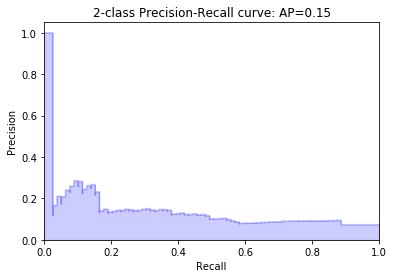

In [201]:
df.loc[:,"class"] = [int(len(set(id_to_pathway_ids[id1]).intersection(set(id_to_pathway_ids[id2])))>0) for (id1,id2) in zip(df["from"].values,df["to"].values)]
#print(df.head(5))
#print(pd.unique(df["class"]))

df["new"] = 1-df["bagofwords"]

# Make sure to remove the self edges, these are not valid positive examples because we can
# already assume that they belong to the exact same groupings or pathways.
df_sub = df[df["from"] != df["to"]]


from sklearn.metrics import precision_recall_curve
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
y_true = df_sub["class"].values
y_scores = df_sub["new"].values


# Subsetting and seeing if things improve.
pos_tuples = [(t,s) for t,s in zip(y_true,y_scores) if t==1]
neg_tuples = [(t,s) for t,s in zip(y_true,y_scores) if t==0]
max_pos_samples = 600000
max_neg_samples = 1000
pos_tuples = pos_tuples[:max_pos_samples]
neg_tuples = neg_tuples[:max_neg_samples]
print(len(pos_tuples))
print(len(neg_tuples))

#https://stats.stackexchange.com/questions/251175/what-is-baseline-in-precision-recall-curve
baseline = len(pos_tuples)/(len(pos_tuples)+len(neg_tuples))
print("Basline is {}".format(baseline))
                           
pos_tuples.extend(neg_tuples)
all_tuples = pos_tuples
y_true = [x[0] for x in all_tuples]
y_scores = [x[1] for x in all_tuples]
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

average_precision = average_precision_score(y_true, y_scores)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

#for i,j in zip(y_true,y_scores):
#    print(i, j)

from inspect import signature

precision, recall, _ = precision_recall_curve(y_true, y_scores)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

area = auc(recall, precision)
print("area is",area)
print("baseline area is",baseline) # the area under teh baseline is just width (1) x height (basline).
print("ratio =", area/baseline)

# Make sure self-edges are being removed? Those are not valid positive samples.
# Are they in there?

# The precision recall curve looks like the things that are predictable are very easily predictable, and 
# everything else is impossible-ish to predict without tanking the precision.
# i.e., a big percentage of cases where two things are mapped to the same pathway is when they are just identical.
# And when they are not identical, then they are impsossible to distinguish from random pairings of genes.

### Predicting which pathway(s) each gene belong to
pathway_id_to_ids = groupings_kegg.get_reverse_dict(genes)This is for classifying nodes in the network as belonging to certain classes or not, rather than classifying edges between the nodes. There are multiple ways that this could be done. The way we used before was just a function over the average similarity to nodes that are known to belong to a specific class (leave-one-out prediction). That takes into account the edges that are in the graph itself, but not information about the node. For example, could a neural network that learns a mapping directly between an embedding as in the input and a class membership vector do any better here? The average similarity thing should be the baseline.

In [204]:
id_to_pathway_ids = groupings_kegg.get_forward_dict(genes)
print("done getting pathways dictionary")

df.loc[:,"class"] = [int(len(set(id_to_pathway_ids[id1]).intersection(set(id_to_pathway_ids[id2])))>0) for (id1,id2) in zip(df["from"].values,df["to"].values)]
df["new"] = 1-df["bagofwords"]
g = IndexedGraph(df=df, value="new")
print("done making the graph")
y_true, y_scores = classification(g, id_to_pathway_ids)
print("done doing the classifying")

from inspect import signature

precision, recall, _ = precision_recall_curve(y_true, y_scores)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

area = auc(recall, precision)
print("area is",area)
print("baseline area is",baseline) # the area under teh baseline is just width (1) x height (basline).
print("ratio =", area/baseline)

done getting pathways dictionary
done making the graph


KeyboardInterrupt: 

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.25)
print(df_train.shape)
print(df_test.shape)

In [ ]:
df_train.loc[:,"class"] = [int(len(set(id_to_pathway_ids[id1]).intersection(set(id_to_pathway_ids[id2])))>0) for (id1,id2) in zip(df_train["from"].values,df_train["to"].values)]
print(df_train.head(20))
print(len(df_train[df_train["class"]==0]))
print(len(df_train[df_train["class"]==1]))